# Lab: Comparing Bag-of-Words, TF-IDF, and Embeddings  
**Task:** News outlet classification (+ a quick semantic search demo)

**Dataset:** `ik-news.csv` with columns  
`id, title, publication, author, date, year, month, url, content`  
**Text column:** `content`  **Label column:** `publication`

## What we'll show today (≈60 min)
1. **Prep the dataset**: quick schema checks, light normalization (lowercase), and label distribution.
2. **Leakage guard**: remove source cues (publisher names, URLs, datelines/bylines) and dedupe/group-split to make evaluation fair.
3. **Bag-of-Words (BoW)**: unigrams & bigrams; look at frequent terms and train a simple linear classifier.
4. **TF-IDF**: swap counts for TF-IDF weights and compare to BoW on the same train/test split.
5. **Embeddings (CBOW)**: train tiny word vectors → build document vectors (mean & TF-IDF-weighted) → compare.
6. **Semantic search**: show where embeddings shine by retrieving meaning-matched articles.

**Why this lab?**  
- See how **feature choices** (counts vs TF-IDF vs embeddings) affect performance.  
- Learn to **detect and remove leakage** so results reflect real generalization.  
- Build a mental model: BoW/TF-IDF excel at **style/phrases**, embeddings at **meaning**.

## 0) Setup

In [69]:
# If needed (e.g., on Colab), uncomment:
# !pip install scikit-learn pandas numpy matplotlib gensim

In [70]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from itertools import chain

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
STOPWORDS = set(ENGLISH_STOP_WORDS)
STOPWORDS.update({'com', 'http', 'https', 'www'})
STOPWORDS = sorted(STOPWORDS)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 5)

## Part 1 — Dataset prep (what & why)

**Goal:** Make sure the corpus is usable and the label is sane before we vectorize.

**What we do**
- **Load** `ik-news.csv` and confirm we have the expected columns.
- **Pick** our working fields:  
  - `text_col = "content"` (article body)  
  - `label_col = "publication"` (Fox News / New York Times / Reuters)
- **Minimal normalize** the text to `text_norm` via **lowercasing + strip** (we do *not* remove stopwords here).
- **Sanity checks**:
  - Drop rows where `content` is missing.
  - Look at **document length** stats (very short docs are often noise).
  - Inspect **label distribution** (class imbalance affects accuracy).

**Why keep stopwords in prep?**  
Stopwords, numbers, and punctuation decisions are **feature-engineering choices** that we want to toggle per method (BoW vs TF-IDF vs embeddings). If we delete them here, we can’t A/B those choices later. So: prep = light & reversible; filtering happens in vectorizers.

In [71]:
df = pd.read_csv('ik-news.csv')
df.shape

(1139, 9)

In [72]:
text_col = 'content'
label_col = 'publication'
df[[text_col, label_col]].head(3)

,content,publication
0,"MONTAGUE, Mass. — Think of all the dogs out...",New York Times
1,WASHINGTON — Gov. Terry McAuliffe of Virgin...,New York Times
2,WASHINGTON — The Supreme Court on Wednesday...,New York Times


In [73]:
# Compute % of rows where the text column is null (missing)
null_rate = df[text_col].isna().mean()
print(f"Null rate in text_col: {null_rate:.3f}")

# Drop rows with missing text so vectorizers don't crash
df = df[df[text_col].notna()].copy()

# Quick sanity check on document lengths (characters)
doc_lengths = df[text_col].astype(str).str.len()
print(doc_lengths.describe())   # shows count/mean/std/min/percentiles/max

# If a label column exists, show top label counts (helps spot imbalance)
if label_col in df.columns:
    print("\nLabel distribution (top 10):")
    print(df[label_col].value_counts().head(10))

Null rate in text_col: 0.000
count     1139.000000
mean      4839.935031
std       2685.199097
min        109.000000
25%       2979.000000
50%       4439.000000
75%       6256.500000
max      27119.000000
Name: content, dtype: float64

Label distribution (top 10):
publication
New York Times    478
Fox News          360
Reuters           301
Name: count, dtype: int64


What “normalize” means here:
* Lowercasing → “Apple” and “apple” become the same token.
* Strip → removes stray spaces at the start/end.

This is intentionally lightweight; we leave stopword removal, token pattern choices, etc. to the vectorizers, so we can A/B those per method.

In [74]:
def normalize(s: str) -> str:
    # minimal normalization: make lowercase and trim outer whitespace
    return str(s).lower().strip()

# Create a working text column used by all later steps
df['text_norm'] = df[text_col].apply(normalize)
df['text_norm'].head(3)

,text_norm
0,"montague, mass. — think of all the dogs out..."
1,washington — gov. terry mcauliffe of virgin...
2,washington — the supreme court on wednesday...


## Part 2 — Leakage guard (what & why)

**Problem:** Publisher/source classification can be trivially “solved” if the text contains **explicit source markers** — e.g., “(Reuters)”, “nytimes.com”, “— Fox News —”, or bylines like “Reporting by …”. If those tokens cross into your features, models learn the shortcut and inflated scores follow.

**What we remove**
- **URLs & bare domains** (e.g., `foxnews.com`, `nytimes.com`, `reuters.com`) — these often tokenize into junk bigrams like `foxnews com`.
- **Publisher variants** with/without spaces/dots (e.g., `fox news`, `foxnews`, `ny times`, `nytimes`), including obvious aliases.
- **Datelines/bylines boilerplate** at the top or tail (e.g., `WASHINGTON (Reuters) —`, `Reporting by ...`, `Contributed to this report`).

**How we do it**
- Build a **regex scrubber** that:
  1) strips URLs/domains,  
  2) removes publisher name variants,  
  3) deletes common dateline/byline shells,  
  4) collapses whitespace.  
- Apply it to **`title` + `content`**, then set `text_norm = text_clean.lower().strip()` so all later vectorizers use the cleaned text.
- **Deduplicate exact repeats** (`title` + `content`) to avoid the same wire story in both train and test.
- Use a **group-aware split** by `url` or `title` so near-duplicates don’t straddle train/test.

**Why this matters**
- After this guard, high scores indicate the model is picking up **style and phrasing patterns**, not literal source names.  
- It also makes BoW vs TF-IDF vs embeddings a **fair comparison**: we’re testing representations, not leakages.

After training, inspect **top features per class** (for BoW/TF-IDF). If you still see `foxnews`, `nytimes`, or raw domains, tighten the scrub and/or add URL tokens like `com/http/www` to your vectorizer stopwords.

In [75]:
# ---- A) Remove URLs and bare domains (e.g., foxnews.com, nytimes.com, reuters.com) ----
URL_OR_DOMAIN = re.compile(
    r'(https?://\S+|www\.\S+|\b[a-z0-9][a-z0-9-]+(?:\.[a-z0-9-]+)+(?:/\S*)?)',
    flags=re.I
)
def strip_urls_domains(t: str) -> str:
    return URL_OR_DOMAIN.sub(' ', str(t))

# ---- B) Scrub outlet name variants (spaces/dots/hyphens optional) ----
OUTLET_STRONG = re.compile(r"""
\b(
    reuters(?:\s*[\.\-]?\s*com)? |
    fox(?:\s*[-\s]*news(?:\s*channel)?) |
    foxnews(?:\s*[\.\-]?\s*com)? |
    (?:the\s+)?new\s+york\s+times |
    newyorktimes |
    ny\s*times |
    nytimes(?:\s*[\.\-]?\s*com)?
)\b
""", flags=re.I | re.X)

# ---- C) Optional wire-service cues (they had appeared in the top features when I first ran this) ----
WIRE_CUES = re.compile(r"\bassociated\s+press\b|\bap\s*news\b|\bapnews\b", flags=re.I)
REMOVE_WIRE_CUES = True  # set False if you want to keep AP mentions

# ---- D) Dateline/byline shells (handles — or -) + end-of-article bylines ----
DATELINE_PAT = re.compile(r"^\s*[A-Z][A-Z\s\.,'&-]+(?:\(\s*reuters\s*\))?\s*[—-]\s*", re.I)
BYLINE_PAT   = re.compile(
    r"(reporting by|with reporting by|edited by|editing by|writing by|contributed by|contributed to this report).*$",
    re.I
)

def strict_scrub(title: str, content: str) -> str:
    s = f"{str(title)}. {str(content)}"
    s = strip_urls_domains(s)
    s = OUTLET_STRONG.sub(' ', s)
    if REMOVE_WIRE_CUES:
        s = WIRE_CUES.sub(' ', s)
    s = re.sub(DATELINE_PAT, ' ', s)
    s = re.sub(BYLINE_PAT, ' ', s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# ---- Apply once to build working text ----
df['text_clean'] = [
    strict_scrub(t, c) for t, c in zip(df['title'].astype(str), df['content'].astype(str))
]
df['text_norm'] = df['text_clean'].map(normalize)

# ---- Deduplicate exact repeats (helps with split leakage) ----
df = df.drop_duplicates(subset=['title', 'content']).copy()

print("After leakage guard — rows:", len(df))
print(df['text_norm'].head(1).item()[:300], "...")

After leakage guard — rows: 1139
think of all the dogs out there: labradors and poodles and labradoodles huskies and westies and dogues de bordeaux pit bulls and spaniels and lovable mutts that go to doggy day care. add them up, all the pet dogs on the planet, and you get about 250 million. but there are about a billion dogs on ear ...


What “group-aware split” means:
* Instead of randomly splitting rows, we split by groups (URL/title).
* All items with the same group value stay together (avoid the same article or its near-duplicate showing up in both train and test).
* This gives you a more honest estimate of generalization by reducing accidental data leakage.

In [76]:
# === Single source of truth: group-aware train/test split ===
label_col = 'publication' if 'label_col' not in globals() else label_col

# Group by URL; fall back to title when URL is missing
groups = df['url'].fillna(df['title']).astype(str)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=groups))

# Canonical variables used everywhere below
# Reset index to keep lengths aligned when you later convert to arrays
# or build DataFrames (no lingering original indices).
X_train_txt = df.loc[train_idx, 'text_norm'].reset_index(drop=True)
X_test_txt  = df.loc[test_idx,  'text_norm'].reset_index(drop=True)
y_train     = df.loc[train_idx, label_col].reset_index(drop=True)
y_test      = df.loc[test_idx,  label_col].reset_index(drop=True)

print(f"Group-aware split ✔  train={len(X_train_txt)}  test={len(X_test_txt)}")

Group-aware split ✔  train=911  test=228


## 3) Manual BoW (hand-built to see the mechanics)

We take a tiny sample of documents, tokenize them with a simple regex, build a vocabulary (word → column index), and manually fill a document–term matrix counting how many times each word appears in each doc. It’s BoW from first principles so you can see how simple the mechanics are.

In [77]:
# --- Tokenize: split on letters/apostrophes so "don't" -> ["don", "t"]
TOKEN_RE = re.compile(r"[A-Za-z']+")
def tokenize(text: str):
    return TOKEN_RE.findall(text)

# Grab a tiny slice so it’s easy to inspect
sample_docs = df['text_norm'].head(6).tolist()
sample_tokens = [tokenize(doc) for doc in sample_docs]

# Build a vocabulary by frequency: most common word gets column 0, etc.
vocab_counts = Counter(chain.from_iterable(sample_tokens))
vocab = {w: i for i, (w, _) in enumerate(vocab_counts.most_common())}
print('Tiny sample vocab size =', len(vocab))

# Allocate a dense doc-term matrix (rows: docs, cols: vocab), then fill counts
X_demo = np.zeros((len(sample_tokens), len(vocab)), dtype=int)
for d, toks in enumerate(sample_tokens):
    for w in toks:
        X_demo[d, vocab[w]] += 1

print('X_demo shape:', X_demo.shape)   # (#docs, #unique_words)
X_demo[:3, :10]                        # peek at first 3 docs / first 10 vocab cols

Tiny sample vocab size = 1882
X_demo shape: (6, 1882)


array([[106,  54,  66,  50,  73,  53,  41,  80,  18,  49],
       [ 66,  45,  30,  31,  21,  34,  20,   0,  19,   4],
       [ 60,  33,  34,  24,  18,  21,  28,   0,  15,   2]])

## 4) Scikit-learn BoW (unigrams)

Same idea as the manual build, but using CountVectorizer to tokenize, build a vocabulary, and produce a sparse document–term matrix efficiently for thousands of documents.

We also add filters to keep the vocabulary informative and manageable:
* `min_df=2` → Minimum document frequency.

A term must appear in at least 2 documents to be kept.

* This removes extremely rare words, typos, or single-use names that add noise but little predictive power.
* Example: if a word only occurs once in a 1000-article corpus, it probably doesn’t generalize well.
* `max_df` (optional) → Maximum document frequency.

A term appearing in too many documents (e.g., >70%) is usually too generic (“said”, “news”, “the”).
Setting `max_df=0.7` tells the vectorizer to drop words that appear in more than 70% of documents, since they don’t help distinguish classes

* `stop_words=STOPWORDS` → removes common function words (“the”, “and”, “of”) that rarely carry signal.
* `max_features=20000` → keeps only the top-20k most frequent terms, ensuring the matrix stays a reasonable size.

Together, these parameters balance coverage (keep enough distinctive terms) and noise reduction (drop words that are too rare or too common).

In [78]:
# Configure a unigram (single-word) count vectorizer
vectorizer_uni = CountVectorizer(
    lowercase=True,           # lowercase during vectorization
    ngram_range=(1,1),        # unigrams only
    min_df=2,                 # keep tokens that appear in >= 2 docs
    stop_words=STOPWORDS,     # shared stopword list (keeps mr/ms)
    max_features=20000        # cap vocab to the top 20k features
)

# Fit on the whole corpus text, then transform to a sparse matrix
X_uni = vectorizer_uni.fit_transform(df['text_norm'])
print('X_uni shape (docs × vocab):', X_uni.shape)

# Inspect the most frequent unigrams overall (sum counts per column)
term_counts = np.asarray(X_uni.sum(axis=0)).ravel()
terms = vectorizer_uni.get_feature_names_out()
order = term_counts.argsort()[::-1]

print("Top unigrams:")
for idx in order[:25]:
    print(f"{terms[idx]:<20} {int(term_counts[idx])}")

X_uni shape (docs × vocab): (1139, 18173)
Top unigrams:
said                 8422
mr                   4813
trump                3330
people               1935
clinton              1904
new                  1578
state                1527
percent              1253
like                 1236
time                 1120
years                1062
year                 1060
president            1054
campaign             1038
told                 1035
just                 1027
states               1013
obama                960
did                  944
united               870
party                821
officials            782
republican           780
world                750
government           744


## 5) Scikit‑learn BoW (unigrams + bigrams)

Unigrams catch which words occur; bigrams add short phrases/collocations (e.g., mr trump, white house), which often carry outlet style and disambiguate meaning.

In [79]:
# Uni+Bi-gram vectorizer: same filters, now ngram_range=(1,2)
vectorizer_uni_bi = CountVectorizer(
    lowercase=True,
    ngram_range=(1,2),        # include unigrams and bigrams
    min_df=2,
    stop_words=STOPWORDS,
    max_features=30000
)

X_uni_bi = vectorizer_uni_bi.fit_transform(df['text_norm'])
print('X_uni_bi shape (docs × vocab):', X_uni_bi.shape)

# Compare vocabulary sizes
print('Unigram vocab:', len(vectorizer_uni.get_feature_names_out()))
print('Uni+Bi vocab:', len(vectorizer_uni_bi.get_feature_names_out()))

# Look at frequent bigrams (filter terms that contain a space)
terms_ub = vectorizer_uni_bi.get_feature_names_out()
counts_ub = np.asarray(X_uni_bi.sum(axis=0)).ravel()
order_ub = counts_ub.argsort()[::-1]

print("Frequent bigrams:")
n = 40
top_pairs = [(terms_ub[i], int(counts_ub[i])) for i in order_ub[:n] if ' ' in terms_ub[i]]
for t, c in top_pairs[:20]:
    print(f"{t:<30} {c}")

X_uni_bi shape (docs × vocab): (1139, 30000)
Unigram vocab: 18173
Uni+Bi vocab: 30000
Frequent bigrams:
mr trump                       1323
united states                  736


## 6) Quick baseline classifier on BoW

We split into train/test (reusing the group-aware split), build BoW(1,2) features, and train a simple Logistic Regression classifier to predict the publication. Then we print overall accuracy and a per-class precision/recall/F1 report.

For sparse, high-dimensional n-gram features, a linear model (LogReg/LinearSVC) is fast, robust, and typically near state-of-the-art for bag-of-words style tasks.

In [80]:
# BoW features with unigrams+bigrams (counts). Switch to binary=True if desired.
bow = CountVectorizer(
    lowercase=True,
    ngram_range=(1,2),
    min_df=2,
    max_features=30000,
    stop_words=STOPWORDS,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z'-]{1,}\b"
)
X_train = bow.fit_transform(X_train_txt)
X_test  = bow.transform(X_test_txt)

# Linear classifier on sparse features (strong baseline for text)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

# Evaluation
print('Accuracy:', accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

Accuracy: 0.8114035087719298
                precision    recall  f1-score   support

      Fox News       0.69      0.84      0.76        61
New York Times       0.99      0.81      0.89       110
       Reuters       0.70      0.79      0.74        57

      accuracy                           0.81       228
     macro avg       0.79      0.81      0.80       228
  weighted avg       0.84      0.81      0.82       228




---
# Part 2: TF‑IDF (Term Frequency × Inverse Document Frequency)


## 1) Unigram TF‑IDF

Instead of raw counts, weight each term by how specific it is to fewer documents.

* TF (term frequency): how often a term appears in a document.
* IDF (inverse document frequency): larger for rare terms, smaller for common ones.
* Combined (TF×IDF) = highlight terms that are frequent in this doc but not everywhere.

Key params here:

* `min_df=2`: drop terms that occur in only 1 doc (likely noise).
* `stop_words=STOPWORDS`: remove common function words.
* `norm='l2'`: per-document L2 normalization (so long docs don’t dominate).
* `use_idf=True, smooth_idf=True`: standard TF-IDF with smoothing.

In [81]:
# === Unigram TF-IDF ===
tfidf_uni = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,1),          # unigrams only
    min_df=2,
    stop_words=STOPWORDS,
    max_features=20000,
    norm='l2',                  # length-normalize each row vector
    use_idf=True, smooth_idf=True
)

X_tfidf_uni = tfidf_uni.fit_transform(df['text_norm'])
print('TF-IDF unigram shape:', X_tfidf_uni.shape)

# Inspect the IDF part: low IDF = common; high IDF = rare
terms = tfidf_uni.get_feature_names_out()
idf = tfidf_uni.idf_
order_low  = idf.argsort()           # most common first
order_high = idf.argsort()[::-1]     # rarest first

print('Common terms (lowest IDF):')
for i in order_low[:15]:
    print(f"{terms[i]:<20} idf={idf[i]:.3f}")

print('\nRare terms (highest IDF):')
for i in order_high[:15]:
    print(f"{terms[i]:<20} idf={idf[i]:.3f}")

TF-IDF unigram shape: (1139, 18173)
Common terms (lowest IDF):
said                 idf=1.090
people               idf=1.492
new                  idf=1.584
time                 idf=1.637
like                 idf=1.713
did                  idf=1.738
years                idf=1.742
just                 idf=1.758
year                 idf=1.791
told                 idf=1.795
state                idf=1.840
president            idf=1.869
including            idf=1.903
states               idf=1.966
week                 idf=1.989

Rare terms (highest IDF):
zookeepers           idf=6.940
zora                 idf=6.940
085                  idf=6.940
077                  idf=6.940
0600                 idf=6.940
05                   idf=6.940
04                   idf=6.940
100th                idf=6.940
liberally            idf=6.940
01                   idf=6.940
liang                idf=6.940
élan                 idf=6.940
liaison              idf=6.940
libraries            idf=6.940
zingers    

In [82]:

for r in df.sample(3, random_state=1).index:
    row = X_tfidf_uni[r].toarray().ravel()
    top_idx = row.argsort()[::-1][:10]
    print(f"\nDoc {r} — top TF‑IDF terms:")
    for j in top_idx:
        if row[j] > 0:
            print(f"  {terms[j]:<25} {row[j]:.3f}")



Doc 833 — top TF‑IDF terms:
  veterans                  0.540
  heroes                    0.268
  fundraiser                0.191
  ptsd                      0.143
  therapy                   0.137
  organization              0.131
  enforcement               0.130
  injuries                  0.124
  team                      0.109
  vets                      0.102

Doc 1123 — top TF‑IDF terms:
  cleveland                 0.283
  demonstrators             0.267
  aclu                      0.232
  convention                0.213
  zone                      0.210
  square                    0.209
  organize                  0.186
  protesters                0.161
  protests                  0.161
  event                     0.152

Doc 584 — top TF‑IDF terms:
  criminal                  0.355
  clinton                   0.315
  inquiry                   0.267
  probe                     0.263
  earnest                   0.222
  email                     0.186
  justice                   

## 2) TF‑IDF (unigrams + bigrams)

Bigrams capture short phrases/collocations (e.g., `mr trump`, `white house`) that unigrams can’t. This often helps for style/source tasks, where wording patterns matter.

In [83]:
# === TF-IDF with unigrams + bigrams ===
tfidf_uni_bi = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),          # unigrams + bigrams
    min_df=2,
    stop_words=STOPWORDS,
    max_features=30000,
    norm='l2', use_idf=True, smooth_idf=True
)

X_tfidf_uni_bi = tfidf_uni_bi.fit_transform(df['text_norm'])
print('TF-IDF (1,2) shape:', X_tfidf_uni_bi.shape)

# Show high-weight n-grams overall (sum TF-IDF across docs, then sort)
terms_ub = tfidf_uni_bi.get_feature_names_out()
weights_sum = np.asarray(X_tfidf_uni_bi.sum(axis=0)).ravel()
order = weights_sum.argsort()[::-1]

print('High-weight n-grams overall:')
for i in order[:25]:
    print(f"{terms_ub[i]:<30} {weights_sum[i]:.2f}")

TF-IDF (1,2) shape: (1139, 30000)
High-weight n-grams overall:
said                           59.68
mr                             51.81
trump                          49.93
clinton                        31.84
mr trump                       22.36
people                         19.61
percent                        19.10
state                          18.39
new                            16.31
mateen                         16.06
obama                          15.46
campaign                       15.09
police                         14.51
orlando                        13.80
sanders                        13.69
party                          13.21
told                           13.10
president                      13.02
like                           12.62
britain                        12.44
republican                     12.39
states                         12.26
year                           12.02
mrs                            11.76
gun                            11.73


## 3) Quick comparison: BoW(1,2) vs TF‑IDF(1,2)

Train two logis:tic-regression models on the same split: one with BoW(1,2) counts, and one with TF-IDF(1,2). Then compare accuracy.

* Expect BoW to do well on style/source; TF-IDF can be similar or slightly lower because it downweights frequent stylistic tokens.

In [84]:
# BoW
bow = CountVectorizer(lowercase=True, ngram_range=(1,2), min_df=2, max_features=30000)
Xtr_bow = bow.fit_transform(X_train_txt); Xte_bow = bow.transform(X_test_txt)
acc_bow = accuracy_score(y_test, LogisticRegression(max_iter=1000).fit(Xtr_bow, y_train).predict(Xte_bow))

# TF-IDF
tfidf = TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2, max_features=30000)
Xtr_tf = tfidf.fit_transform(X_train_txt); Xte_tf = tfidf.transform(X_test_txt)
acc_tf = accuracy_score(y_test, LogisticRegression(max_iter=1000).fit(Xtr_tf, y_train).predict(Xte_tf))

print(f"Accuracy — BoW(1,2):   {acc_bow:.3f}")
print(f"Accuracy — TF-IDF(1,2): {acc_tf:.3f}")

Accuracy — BoW(1,2):   0.873
Accuracy — TF-IDF(1,2): 0.877


## 4) Class‑wise top TF‑IDF terms (diagnostics)

Summing TF-IDF vectors over all docs of a class highlights class-salient n-grams (bigrams often reveal style). This helps you interpret what the model finds distinctive.

In [85]:
# === Per-class top TF-IDF n-grams ===
terms_cls = tfidf_uni_bi.get_feature_names_out()
X = X_tfidf_uni_bi

top_labels = df[label_col].value_counts().head(3).index.tolist()
for lab in top_labels:
    rows = df[df[label_col] == lab].index
    vec = X[rows].sum(axis=0).A1     # sum TF-IDF across rows of this class
    top_idx = vec.argsort()[::-1][:20]
    print(f"\nTop TF-IDF terms for label: {lab}")
    for j in top_idx:
        print(f"  {terms_cls[j]:<30} {vec[j]:.2f}")


Top TF-IDF terms for label: New York Times
  mr                             50.94
  said                           27.85
  trump                          23.43
  mr trump                       22.10
  clinton                        11.69
  mrs clinton                    11.47
  mrs                            11.42
  ms                             11.08
  people                         9.50
  _____                          8.40
  like                           8.17
  new                            7.41
  campaign                       7.19
  state                          6.86
  states                         6.84
  party                          6.61
  united                         6.40
  years                          6.30
  just                           6.25
  britain                        6.17

Top TF-IDF terms for label: Fox News
  trump                          17.63
  clinton                        15.99
  said                           14.63
  mateen                         

## 5) Cosine similarity mini‑demo

TF-IDF vectors let us measure document similarity with cosine (angle).

* Values near 1.0 → very similar; closer to 0 → dissimilar.

In [86]:
# === Cosine similarity between documents in TF-IDF space ===
from sklearn.metrics.pairwise import cosine_similarity

A = X_tfidf_uni_bi[df.index[:1]]      # first doc
B = X_tfidf_uni_bi[df.index[1:3]]     # next two docs
cos = cosine_similarity(A, B)
print('Cosine(doc0, doc1) =', round(float(cos[0,0]), 3))
print('Cosine(doc0, doc2) =', round(float(cos[0,1]), 3))

Cosine(doc0, doc1) = 0.011
Cosine(doc0, doc2) = 0.013


* IDF intuition: If a word appears in every article, its IDF is small → it won’t dominate.
* When TF-IDF beats BoW: topic retrieval, deduplication, and tasks where frequent function words are noise rather than signal.
* When BoW can win: source/style labeling where frequent collocations are genuinely informative.


---
# Part 3: Embeddings (CBOW) → Document Vectors


## 1) Train Word2Vec (CBOW)

We learn word embeddings from our corpus using Word2Vec (CBOW). CBOW predicts a word from its surrounding context → smooths meaning over local windows.

Parameters to note:

* `vector_size=100` → dimensionality of each word vector (trade-off: expressiveness vs speed).
* `window=5` → how many words left/right define “context”.
* `min_count=2` → ignore very rare words (reduces noise, speeds training).
* `sg=0` → CBOW (set sg=1 for Skip-gram, which can help rarer words).
* `epochs=10` → passes over the data (more = better but slower).
* `seed=42` → reproducibility.

Embeddings capture semantic similarity (e.g., price near market), not just shared spelling. This helps when wording changes but meaning doesn’t.


In [87]:
# === Train Word2Vec (CBOW) on our cleaned corpus ===
try:
    from gensim.models import Word2Vec
except Exception as e:
    print("If gensim is missing, run: pip install gensim")
    raise

# Simple tokenizer consistent with earlier sections
TOKEN_RE = re.compile(r"[A-Za-z']+")
def tokenize(text: str):
    return TOKEN_RE.findall(str(text).lower())

# Tokenize every document; feed to Word2Vec (CBOW)
sentences = [tokenize(t) for t in df['text_norm']]

w2v = Word2Vec(
    sentences=sentences,
    vector_size=100,   # embedding size
    window=5,          # context window
    min_count=2,       # ignore words seen < 2 times
    workers=4,         # CPU threads
    sg=0,              # 0 = CBOW, 1 = Skip-gram
    epochs=10,
    seed=42
)

wv = w2v.wv  # keyed vectors (lookups & similarity live here)
print('Vocab size:', len(wv))
print('Vector size:', wv.vector_size)

# Quick sanity check: nearest neighbors for a few terms (if present)
query_terms = ['government','market','court','football','climate','china','inflation','white','house']
for q in query_terms:
    if q in wv.key_to_index:
        print(f"\nMost similar to '{q}':")
        for w, s in wv.most_similar(q, topn=5):
            print(f"  {w:<15} {s:.3f}")

Vocab size: 20139
Vector size: 100

Most similar to 'government':
  military        0.745
  coalition       0.722
  syrian          0.696
  diplomatic      0.695
  nato            0.690

Most similar to 'market':
  price           0.835
  stock           0.830
  markets         0.824
  growth          0.822
  global          0.789

Most similar to 'court':
  ruling          0.800
  supreme         0.772
  decision        0.732
  appeals         0.724
  justices        0.723

Most similar to 'football':
  legend          0.767
  lonnie          0.746
  male            0.745
  basketball      0.734
  teenage         0.734

Most similar to 'climate':
  unprecedented   0.683
  emerges         0.675
  broadband       0.670
  fundamentally   0.663
  treaty          0.650

Most similar to 'china':
  japan           0.815
  korea           0.805
  sea             0.795
  india           0.791
  nato            0.781

Most similar to 'inflation':
  growth          0.878
  increases       0.852


## 2) Build document vectors (mean and TF‑IDF‑weighted mean)

We turn each document into one fixed-length vector by pooling its word vectors.
* Mean pooling: average all word vectors in the doc → simple, fast baseline.
* TF-IDF-weighted mean: weigh each word vector by its importance in that doc (TF-IDF) → downweights boilerplate.

Edge cases handled:

* If a document has no in-vocab words, we return a zero vector.
* TF-IDF weights are fit on the train split only; we use the trained vocabulary to weight test docs (prevents leakage).

In [88]:
# === Turn text into document vectors (two ways) — using the canonical split ===

# Dimension of each word vector from your trained Word2Vec model
EMB_DIM = wv.vector_size

def docvec_mean(tokens, wv, dim):
    """Return the mean (average) of in-vocabulary word vectors.
    If a doc has no tokens in the embedding vocab, return a zero vector."""
    vecs = [wv[t] for t in tokens if t in wv.key_to_index]
    return np.mean(vecs, axis=0) if vecs else np.zeros(dim, dtype=np.float32)

# Tokenize the already-split train/test texts
# (tokenize should match how you trained Word2Vec: lowercase, A–Z + apostrophes)
train_tokens = [tokenize(t) for t in X_train_txt]
test_tokens  = [tokenize(t) for t in X_test_txt]

# --- Fit TF-IDF (on TRAIN only) to get per-term weights for weighting word vectors ---
# Using unigrams; you can keep this aligned with your earlier word-model policy by
# adding stop_words=STOPWORDS and a token_pattern if desired.
tfidf_train = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,1),
    min_df=2,
    max_features=20000
    # Optional for consistency:
    # stop_words=STOPWORDS,
    # token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z'-]{1,}\b"
)

# Learn TF (and IDF) statistics from TRAIN, then transform TRAIN and TEST
Xtr_tfidf = tfidf_train.fit_transform(X_train_txt)
Xte_tfidf = tfidf_train.transform(X_test_txt)

# Map: term -> column index in the TF-IDF matrix (needed to match tokens to weights)
term_to_col = tfidf_train.vocabulary_

def docvec_tfidf(tokens, tfidf_row, wv, dim, term_to_col):
    """Return a TF-IDF-weighted average of word vectors for one doc.
    If all weights are zero or no tokens are in-vocab, fall back to mean/zeros."""
    if tfidf_row.nnz == 0:  # quick exit if the row is empty
        return np.zeros(dim, dtype=np.float32)

    # Sparse row -> dict of {column_index: weight} for fast lookup
    inds = tfidf_row.indices
    data = tfidf_row.data
    col_to_w = {col: wt for col, wt in zip(inds, data)}

    acc = np.zeros(dim, dtype=np.float32)
    Z = 0.0  # normalization constant (sum of weights actually used)
    for t in tokens:
        col = term_to_col.get(t)             # which column corresponds to token t?
        if col is not None and t in wv.key_to_index:
            w = col_to_w.get(col, 0.0)       # TF-IDF weight for token t in THIS doc
            if w > 0:
                acc += w * wv[t]             # accumulate weighted word vector
                Z += w
    return acc / Z if Z > 0 else docvec_mean(tokens, wv, dim)

# --- Build the two document-vector matrices (TRAIN and TEST) ---

# 1) Mean-pooled embeddings
Xtr_emb_mean = np.vstack([docvec_mean(tok, wv, EMB_DIM) for tok in train_tokens])
Xte_emb_mean = np.vstack([docvec_mean(tok, wv, EMB_DIM) for tok in test_tokens])

# 2) TF-IDF–weighted mean embeddings
#    (use the TF-IDF row for each document to weight its tokens)
Xtr_emb_tfidf = np.vstack([
    docvec_tfidf(train_tokens[i], Xtr_tfidf[i], wv, EMB_DIM, term_to_col)
    for i in range(len(train_tokens))
])
Xte_emb_tfidf = np.vstack([
    docvec_tfidf(test_tokens[i],  Xte_tfidf[i], wv, EMB_DIM, term_to_col)
    for i in range(len(test_tokens))
])

# Shapes sanity check: (n_train, emb_dim), (n_test, emb_dim) for both variants
Xtr_emb_mean.shape, Xte_emb_mean.shape, Xtr_emb_tfidf.shape, Xte_emb_tfidf.shape

((911, 100), (228, 100), (911, 100), (228, 100))

## 3) Baseline classifier on document embeddings

Train Logistic Regression on the two document-vector variants and compare accuracy & per-class metrics.

* Expect these to trail strong n-gram baselines for source/style prediction.
* They shine more on semantic tasks (see the later search demo).

In [89]:
# === Classify with doc embeddings ===
clf_mean = LogisticRegression(max_iter=2000).fit(Xtr_emb_mean, y_train)
pred_mean = clf_mean.predict(Xte_emb_mean)

clf_w = LogisticRegression(max_iter=2000).fit(Xtr_emb_tfidf, y_train)
pred_w = clf_w.predict(Xte_emb_tfidf)

print('Accuracy — Mean embeddings :', round(accuracy_score(y_test, pred_mean), 3))
print('Accuracy — TF-IDF-weighted:', round(accuracy_score(y_test, pred_w), 3))
print('\nPer-class report (weighted embeddings):')
print(classification_report(y_test, pred_w))

Accuracy — Mean embeddings : 0.776
Accuracy — TF-IDF-weighted: 0.75

Per-class report (weighted embeddings):
                precision    recall  f1-score   support

      Fox News       0.61      0.70      0.66        61
New York Times       0.91      0.78      0.84       110
       Reuters       0.66      0.74      0.69        57

      accuracy                           0.75       228
     macro avg       0.73      0.74      0.73       228
  weighted avg       0.77      0.75      0.76       228



## 4) Visualize a slice of the word space

Runs PCA to 2D on a small subset of word vectors, scatter them, and label a few points. It’s only for intuition—clusters suggest semantic neighborhoods.

* CBOW vs Skip-gram: CBOW is faster and smooths frequent words; Skip-gram can model rarer words better.
* Where embeddings shine: semantic similarity / retrieval, clustering, transfer to other tasks.

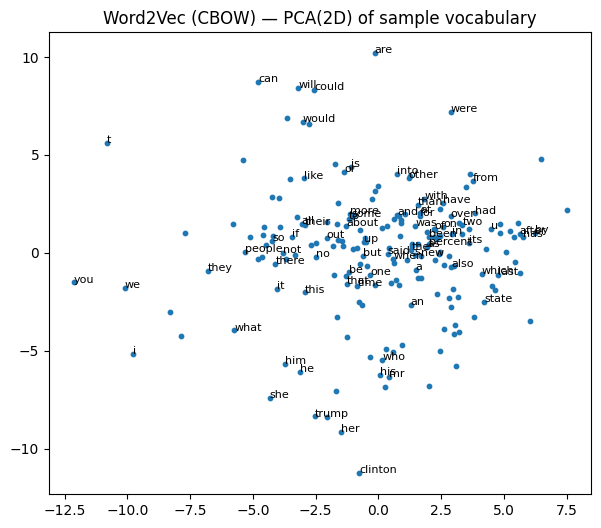

In [90]:
# === Visualize a tiny slice of the learned word space (optional) ===
from sklearn.decomposition import PCA

vocab_items = list(wv.key_to_index.keys())[:200]            # small sample so it's readable
vecs = np.vstack([wv[w] for w in vocab_items])
xy = PCA(n_components=2, random_state=42).fit_transform(vecs)

plt.figure(figsize=(7,6))
plt.scatter(xy[:,0], xy[:,1], s=10)
for (x, y), w in zip(xy, vocab_items[:80]):                 # label a subset
    plt.text(x, y, w, fontsize=8)

plt.title('Word2Vec (CBOW) — PCA(2D) of sample vocabulary')
plt.show()

## 5) Unified Mini-Benchmark (BoW vs TF-IDF vs Char n-grams vs CBOW Embeddings)

Runs a side-by-side comparison of 10 lightweight text classifiers on the same train/test split. You’ll see how simple count features, TF-IDF weighting, character n-grams, and CBOW document embeddings stack up for outlet classification. We keep tokenization/stopword policy consistent across the word models for a fair fight, reuse the already-trained Word2Vec (wv) for embeddings, and report accuracy and macro-F1.

This shows when BoW/TF-IDF dominate (style/source tasks) and where embeddings land without heavy modeling.

In [91]:
# === Unified mini-benchmark: BoW / TF-IDF / Char n-grams / Base Embeddings (CBOW) ===

# Token pattern: letters + apostrophes/hyphens (keeps "mr/ms", "don't", "e-mail"; drops pure numbers)
TOK = r"(?u)\b[a-zA-Z][a-zA-Z'-]{1,}\b"

# ---------- Canonical split (already created earlier) ----------
Xtr, Xte, ytr, yte = X_train_txt, X_test_txt, y_train, y_test  # reuse across all models

# ---------- Helper to run and log experiments ----------
experiments = []
def run(name, pipe):
    """Fit a pipeline on the train split, predict on the test split, log accuracy + macro-F1."""
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xte)
    experiments.append({
        "model": name,
        "acc": accuracy_score(yte, pred),
        "macro_f1": f1_score(yte, pred, average="macro")
    })

# ---------- 1) BoW (counts, uni+bi) + Logistic Regression ----------
# Classic counts; good baseline for style/source tasks.
run("BoW(1,2) counts + LR",
    make_pipeline(
        CountVectorizer(ngram_range=(1,2), min_df=2, max_features=30000,
                        stop_words=STOPWORDS, token_pattern=TOK),
        LogisticRegression(max_iter=1500)
    )
)

# ---------- 2) BoW (binary presence, uni+bi) + LR ----------
# Presence/absence neuters doc length; often best for outlet/style signals.
run("BoW(1,2) binary + LR",
    make_pipeline(
        CountVectorizer(ngram_range=(1,2), min_df=2, max_features=30000, binary=True,
                        stop_words=STOPWORDS, token_pattern=TOK),
        LogisticRegression(max_iter=1500)
    )
)

# ---------- 3) TF-only (L2-normalized) + LR ----------
# TF (no IDF) but with L2 normalization; like counts with length control.
run("TF only (L2) + LR",
    make_pipeline(
        CountVectorizer(ngram_range=(1,2), min_df=2, max_features=30000,
                        stop_words=STOPWORDS, token_pattern=TOK),
        TfidfTransformer(use_idf=False, norm='l2'),
        LogisticRegression(max_iter=1500)
    )
)

# ---------- 4) TF-IDF (uni+bi, defaults) + LR ----------
# Standard TF-IDF; downweights very common tokens globally.
run("TF-IDF(1,2) default + LR",
    make_pipeline(
        TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=30000,
                        stop_words=STOPWORDS, token_pattern=TOK),
        LogisticRegression(max_iter=1500)
    )
)

# ---------- 5) TF-IDF (sublinear TF) + LR ----------
# Sublinear TF (log scaling) reduces the impact of huge raw counts.
run("TF-IDF(1,2) sublinear_tf + LR",
    make_pipeline(
        TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=30000, sublinear_tf=True,
                        stop_words=STOPWORDS, token_pattern=TOK),
        LogisticRegression(max_iter=1500)
    )
)

# ---------- 6) TF-IDF (sublinear TF, no norm) + LR ----------
# Keeps magnitude (more BoW-like) while still log-scaling counts.
run("TF-IDF(1,2) sublinear, no norm + LR",
    make_pipeline(
        TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=30000,
                        sublinear_tf=True, norm=None,
                        stop_words=STOPWORDS, token_pattern=TOK),
        LogisticRegression(max_iter=1500)
    )
)

# ---------- 7) TF-IDF (character 3–5) + LR ----------
# Char n-grams capture surface/style (affixes, punctuation, name shapes).
# Note: stop_words/token_pattern are ignored for char analyzers.
run("TF-IDF char 3–5 + LR",
    make_pipeline(
        TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=5, sublinear_tf=True),
        LogisticRegression(max_iter=1500)
    )
)

# ---------- 8) TF-IDF (uni+bi) + LinearSVC ----------
# Same features as (4), different linear classifier (often ties/edges LR).
run("TF-IDF(1,2) default + LinearSVC",
    make_pipeline(
        TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=30000,
                        stop_words=STOPWORDS, token_pattern=TOK),
        LinearSVC()
    )
)

# ---------- 9–10) BASE EMBEDDINGS (CBOW) — reuse the already-trained `wv` ----------
try:
    wv  # must exist from Part 3
    D = wv.vector_size
except NameError:
    print("Embeddings rows skipped → no `wv` found. Run the Part 3 Word2Vec training cell first.")
else:
    # Use existing tokenize(); if missing, define a compatible fallback matching W2V training.
    if 'tokenize' not in globals():
        TOKEN_RE = re.compile(r"[A-Za-z']+")
        def tokenize(text: str):
            return TOKEN_RE.findall(str(text).lower())

    def docvec_mean(tokens, wv, dim):
        """Mean of in-vocab word vectors; zero vector if none are in-vocab."""
        vecs = [wv[t] for t in tokens if t in wv.key_to_index]
        return np.mean(vecs, axis=0) if vecs else np.zeros(dim, dtype=np.float32)

    # Tokenize the canonical split
    Xtr_tok = [tokenize(t) for t in Xtr]
    Xte_tok = [tokenize(t) for t in Xte]

    # 9) Mean-pooled embeddings + LR
    Xtr_emb_mean = np.vstack([docvec_mean(tok, wv, D) for tok in Xtr_tok])
    Xte_emb_mean = np.vstack([docvec_mean(tok, wv, D) for tok in Xte_tok])
    clf = LogisticRegression(max_iter=2000).fit(Xtr_emb_mean, ytr)
    pred = clf.predict(Xte_emb_mean)
    experiments.append({
        "model": "CBOW mean emb + LR",
        "acc": accuracy_score(yte, pred),
        "macro_f1": f1_score(yte, pred, average="macro")
    })

    # 10) TF-IDF–weighted mean embeddings (fit weights on TRAIN only)
    tf_uni = TfidfVectorizer(
        lowercase=True, ngram_range=(1,1), min_df=2, max_features=20000,
        stop_words=STOPWORDS, token_pattern=TOK
    )
    Xtr_tf = tf_uni.fit_transform(Xtr)   # learn weights on TRAIN
    Xte_tf = tf_uni.transform(Xte)       # apply to TEST
    term_to_col = tf_uni.vocabulary_

    def docvec_tfidf(tokens, tf_row, wv, dim, term_to_col):
        """TF-IDF–weighted average of word vectors; fallback to mean/zeros if no weights apply."""
        if tf_row.nnz == 0:
            return np.zeros(dim, dtype=np.float32)
        inds = tf_row.indices; data = tf_row.data
        col2w = {c:w for c, w in zip(inds, data)}
        acc = np.zeros(dim, dtype=np.float32); Z = 0.0
        for t in tokens:
            col = term_to_col.get(t)
            if col is not None and t in wv.key_to_index:
                w = col2w.get(col, 0.0)
                if w > 0:
                    acc += w * wv[t]; Z += w
        return acc / Z if Z > 0 else docvec_mean(tokens, wv, dim)

    Xtr_emb_w = np.vstack([docvec_tfidf(Xtr_tok[i], Xtr_tf[i], wv, D, term_to_col) for i in range(len(Xtr_tok))])
    Xte_emb_w = np.vstack([docvec_tfidf(Xte_tok[i], Xte_tf[i], wv, D, term_to_col) for i in range(len(Xte_tok))])

    clf = LogisticRegression(max_iter=2000).fit(Xtr_emb_w, ytr)
    pred = clf.predict(Xte_emb_w)
    experiments.append({
        "model": "CBOW TF-IDF-weighted emb + LR",
        "acc": accuracy_score(yte, pred),
        "macro_f1": f1_score(yte, pred, average="macro")
    })

# ---------- Results table ----------
res = pd.DataFrame(experiments)
res['acc'] = res['acc'].round(3)
res['macro_f1'] = res['macro_f1'].round(3)
print(res.sort_values(["macro_f1","acc"], ascending=False).to_string(index=False))

                              model   acc  macro_f1
TF-IDF(1,2) sublinear, no norm + LR 0.877     0.860
               BoW(1,2) binary + LR 0.873     0.858
               TF-IDF char 3–5 + LR 0.868     0.846
      TF-IDF(1,2) sublinear_tf + LR 0.868     0.845
    TF-IDF(1,2) default + LinearSVC 0.851     0.838
           TF-IDF(1,2) default + LR 0.838     0.817
                  TF only (L2) + LR 0.829     0.813
               BoW(1,2) counts + LR 0.811     0.796
                 CBOW mean emb + LR 0.776     0.756
      CBOW TF-IDF-weighted emb + LR 0.737     0.712


## 6) Error Analysis — Confusion Matrix & Top Features

Fits (or reuses) a strong binary BoW (1,2) baseline, then:

1. prints a confusion matrix to show which outlets get confused with which, and
2. lists the top weighted features per class from the logistic regression to interpret what the model is actually using.

Confusions highlight boundary cases; top features make the model’s behavior auditable (and help spot residual leakage).

In [92]:
# If you already trained a binary BoW pipeline earlier, reuse it.
# Otherwise, create one here. (Tip: add stop_words/token_pattern for consistency.)
bin_bow = make_pipeline(
    CountVectorizer(
        ngram_range=(1,2),      # unigrams + bigrams capture short collocations
        min_df=2,               # drop ultra-rare terms
        max_features=30000,     # cap vocab size
        binary=True             # presence/absence (neutralizes doc length)
        # Optional (recommended for consistency with earlier cells):
        # , stop_words=STOPWORDS, token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z'-]{1,}\b"
    ),
    LogisticRegression(max_iter=1500)  # fast, strong linear baseline on sparse text
)

# Fit on the canonical split and predict
bin_bow.fit(Xtr, ytr)
pred = bin_bow.predict(Xte)

# --- Confusion matrix (rows = true labels, cols = predicted labels) ---
cm = confusion_matrix(yte, pred)
cm_df = pd.DataFrame(
    cm,
    index=bin_bow.named_steps['logisticregression'].classes_,
    columns=bin_bow.named_steps['logisticregression'].classes_
)
cm_df  # display nicely in the notebook

# --- Top features per class (largest positive weights in the one-vs-rest logits) ---
vec = bin_bow.named_steps['countvectorizer']
clf = bin_bow.named_steps['logisticregression']
terms = vec.get_feature_names_out()

for cls, coef in zip(clf.classes_, clf.coef_):
    # coef is the weight vector for "this class vs rest"
    top = np.argsort(coef)[-15:][::-1]  # indices of the 15 largest positive weights
    print(f"\nTop features for {cls}:")
    for j in top:
        print(f"  {terms[j]:<25} {coef[j]:.3f}")


Top features for Fox News:
  told                      0.228
  from the                  0.183
  says                      0.179
  terror                    0.163
  com                       0.160
  2016                      0.160
  during                    0.160
  told com                  0.155
  gop                       0.155
  elections from            0.154
  politics see              0.154
  see latest                0.154
  2016 elections            0.154
  biggest name              0.154
  latest coverage           0.154

Top features for New York Times:
  mr                        0.708
  ms                        0.292
  mr trump                  0.220
  said that                 0.192
  had been                  0.171
  here                      0.171
  that he                   0.166
  that mr                   0.161
  of mr                     0.153
  case                      0.143
  and mr                    0.142
  that would                0.141
  here are          

## 7) Semantic Search — TF-IDF (lexical) vs SBERT (semantic)

Builds two search indexes over the corpus:

1. a TF-IDF index that matches on shared words/phrases (lexical overlap), and
2. an SBERT embedding index that matches on meaning (even with different wording).

We call compare_search("your query", k=5) to see the top-k results from both systems side-by-side.

This is a nice demo of where embeddings beat n-grams: paraphrases and synonymy. TF-IDF excels when the query shares surface words with the documents; SBERT shines when it doesn’t.

In [93]:
# === 7) Semantic Search — TF-IDF (lexical) vs Word2Vec (semantic-ish) ===
# Call: compare_search("interest rates hike spooks investors", k=5)

# Inputs for indexing & display
DOCS   = df['text_norm'].tolist()
TITLES = df['title'].astype(str).tolist()
PUBS   = df['publication'].astype(str).tolist() if 'publication' in df.columns else [""]*len(DOCS)

# ----- A) TF-IDF index (lexical) -----
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.7,
    stop_words=STOPWORDS,
    token_pattern=TOK,
    sublinear_tf=True
)
X_tfidf = tfidf.fit_transform(DOCS)

# ----- B) Word2Vec document-embedding index (reuse your trained `wv`) -----
# Expect `wv` (gensim keyed vectors) and `tokenize()` to already exist from Part 3.
try:
    _ = wv.vector_size
except NameError:
    raise RuntimeError("No trained Word2Vec `wv` found. Run the Part 3 training cell first.")

if 'tokenize' not in globals():
    # Fallback compatible with your W2V training tokenizer
    TOKEN_RE = re.compile(r"[A-Za-z']+")
    def tokenize(text: str):
        return TOKEN_RE.findall(str(text).lower())

D = wv.vector_size

def docvec_mean(tokens):
    vecs = [wv[t] for t in tokens if t in wv.key_to_index]
    return np.mean(vecs, axis=0) if vecs else np.zeros(D, dtype=np.float32)

# Build mean-pooled doc vectors
TOKS = [tokenize(t) for t in DOCS]
X_w2v_mean = np.vstack([docvec_mean(tok) for tok in TOKS])

# Optional: TF-IDF–weighted W2V doc vectors (uses the TF-IDF we just fit)
term_to_col = tfidf.vocabulary_
def docvec_tfidf(tokens, tfidf_row):
    if tfidf_row.nnz == 0:
        return np.zeros(D, dtype=np.float32)
    inds = tfidf_row.indices; data = tfidf_row.data
    col2w = {c:w for c,w in zip(inds, data)}
    acc = np.zeros(D, dtype=np.float32); Z = 0.0
    for t in tokens:
        col = term_to_col.get(t)
        if col is not None and t in wv.key_to_index:
            w = col2w.get(col, 0.0)
            if w > 0:
                acc += w * wv[t]; Z += w
    return acc / Z if Z > 0 else docvec_mean(tokens)

X_tfidf_rows = X_tfidf.tocsr()
X_w2v_tfidf = np.vstack([docvec_tfidf(TOKS[i], X_tfidf_rows[i]) for i in range(len(TOKS))])

# Pre-normalize W2V matrices for fast cosine via dot product
def _row_normed(M):
    n = np.linalg.norm(M, axis=1, keepdims=True)
    n[n == 0] = 1.0
    return M / n

X_w2v_mean_n = _row_normed(X_w2v_mean)
X_w2v_tfidf_n = _row_normed(X_w2v_tfidf)

# ----- C) Pretty-printer -----
def _fmt(i, score):
    pub = f"[{PUBS[i]}] " if PUBS and PUBS[i] else ""
    title = TITLES[i][:100].replace("\n"," ")
    return f"{score:5.3f}  {pub}{title}"

# ----- D) Compare search: TF-IDF vs Word2Vec (mean and TF-IDF-weighted) -----
def compare_search(query, k=5, show_w2v_variant="both"):
    """
    show_w2v_variant ∈ {"mean","tfidf","both"}
    """
    q = str(query).strip()
    if not q:
        print("Empty query."); return
    print(f"\nQuery: {q}\n")

    # TF-IDF cosine (lexical overlap)
    q_tfidf = tfidf.transform([q.lower()])
    # cosine with sparse TF-IDF matrix
    from sklearn.metrics.pairwise import cosine_similarity
    sim_tf = cosine_similarity(q_tfidf, X_tfidf)[0]
    top_tf = np.argsort(sim_tf)[-k:][::-1]
    print("TF-IDF (lexical) top-k:")
    for i in top_tf:
        print(" •", _fmt(i, float(sim_tf[i])))

    # Word2Vec: build query vector(s)
    q_tokens = tokenize(q)
    q_vec_mean = docvec_mean(q_tokens)
    q_vec_mean_n = q_vec_mean / (np.linalg.norm(q_vec_mean) + 1e-12)

    # Optional TF-IDF–weighted query vector uses the same tfidf vocabulary/weights
    q_vec_tfidf = None
    if show_w2v_variant in ("tfidf","both"):
        q_tf = tfidf.transform([q.lower()])[0]
        q_vec_tfidf = docvec_tfidf(q_tokens, q_tf)
        q_vec_tfidf_n = q_vec_tfidf / (np.linalg.norm(q_vec_tfidf) + 1e-12)

    # Cosine via dot product (since all are L2-normalized)
    if show_w2v_variant in ("mean","both"):
        sim_mean = X_w2v_mean_n @ q_vec_mean_n
        top_mean = np.argsort(sim_mean)[-k:][::-1]
        print("\nWord2Vec (mean-pooled) top-k:")
        for i in top_mean:
            print(" •", _fmt(i, float(sim_mean[i])))

    if show_w2v_variant in ("tfidf","both") and q_vec_tfidf is not None:
        sim_w = X_w2v_tfidf_n @ q_vec_tfidf_n
        top_w = np.argsort(sim_w)[-k:][::-1]
        print("\nWord2Vec (TF-IDF-weighted) top-k:")
        for i in top_w:
            print(" •", _fmt(i, float(sim_w[i])))

# Example:
# compare_search("interest rates hike spooks investors", k=5)
# compare_search("hurricane landfall florida panhandle", k=5)
# compare_search("underdogs upset champions in penalty shootout", k=5)

In [94]:
queries = [
    "interest rates hike spooks investors",
    "hurricane landfall florida panhandle",
    "underdogs upset champions in penalty shootout",
]
for q in queries:
    compare_search(q, k=5)


Query: interest rates hike spooks investors

TF-IDF (lexical) top-k:
 • 0.180  [Reuters] Dollar recovers some ground after payrolls blow, Yellen in focus
 • 0.134  [Reuters] Don’t know where U.S. stocks are headed? The options market has a deal for you
 • 0.103  [Reuters] ’Abenomics’ doubts drive foreigners off Japanese stocks, volatility spikes
 • 0.100  [Reuters] World stocks tumble as Britain votes for EU exit
 • 0.087  [Reuters] Oil dips on dollar strength, Europe and Asia growth worries

Word2Vec (mean-pooled) top-k:
 • 0.700  [Reuters] Oil dips on dollar strength, Europe and Asia growth worries
 • 0.680  [Reuters] Twilio IPO exceeds expectations, despite Brexit angst
 • 0.673  [Reuters] U.S. banks flex capital muscle in annual stress test
 • 0.670  [Reuters] Rising rents, healthcare costs support U.S. underlying inflation
 • 0.668  [Reuters] Brent crude tumbles to seven-week low on dollar rally, Brexit turmoil

Word2Vec (TF-IDF-weighted) top-k:
 • 0.858  [Reuters] Don’t know whe

## 8) Semantic Search — TF-IDF (lexical) vs Sentence-BERT (SBERT) (semantic)

This is a demo of using transformers, which creates contextual (non static) embeddings. We haven't covered them yet so this is just for interest.

Builds two search indexes over the corpus:

1. a TF-IDF index that matches on shared words/phrases (lexical overlap), and
2. an SBERT embedding index that matches on meaning (even with different wording).

We call compare_search("your query", k=5) to see the top-k results from both systems side-by-side.

This is a higher-level demo showing how transformer embeddings capture deep semantics beyond word vectors.

* TF-IDF excels when the query shares surface words with the documents.
* SBERT shines when it doesn’t — handling paraphrases, synonyms, and context far better than n-gram or Word2Vec models.

In [95]:
# === 7) Semantic Search — TF-IDF (lexical) vs SBERT (semantic) ===
# Call: compare_search("interest rates hike spooks investors", k=5)

# Inputs for indexing & display
DOCS   = df['text_norm'].tolist()
TITLES = df['title'].astype(str).tolist()
PUBS   = df['publication'].astype(str).tolist() if 'publication' in df.columns else [""]*len(DOCS)

# (1) Build TF-IDF index (lexical) — reuses STOPWORDS/TOK from earlier
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.7,
    stop_words=STOPWORDS,
    token_pattern=TOK,
    sublinear_tf=True
)
X_tfidf = tfidf.fit_transform(DOCS)

# (2) Build SBERT index (semantic) with chunking (avoid truncation)
if 'enc' not in globals() or enc is None:
    try:
        from sentence_transformers import SentenceTransformer
        import torch
        device = "cuda" if torch.cuda.is_available() else "cpu"
        enc = SentenceTransformer("all-MiniLM-L6-v2", device=device)
    except Exception as e:
        enc = None
        print("SBERT unavailable →", e)

# Define chunker once (idempotent)
if 'chunk_text' not in globals():
    def chunk_text(t, max_words=250):
        ws = str(t).split()
        return [" ".join(ws[i:i+max_words]) for i in range(0, len(ws), max_words)] or [""]

# Fresh helper to avoid name clashes with any earlier encode_docs
def sbert_encode_docs(texts, encoder, bs=128):
    """Encode each doc by averaging normalized embeddings of its chunks."""
    if encoder is None:
        return None
    embs = []
    for doc in texts:
        chunks = chunk_text(doc)
        E = encoder.encode(
            chunks,
            batch_size=bs,
            normalize_embeddings=True,
            convert_to_numpy=True,
            show_progress_bar=False
        )
        embs.append(E.mean(axis=0))
    return np.vstack(embs)

X_sbert = sbert_encode_docs(DOCS, enc, bs=128)

# (3) Pretty-printer for results
def _fmt(i, score):
    pub = f"[{PUBS[i]}] " if PUBS and PUBS[i] else ""
    title = TITLES[i][:100].replace("\n"," ")
    return f"{score:5.3f}  {pub}{title}"

# (4) Compare search: TF-IDF vs SBERT
def compare_search(query, k=5):
    """Print top-k nearest docs for a free-text query using TF-IDF and SBERT."""
    q = str(query).strip()
    if not q:
        print("Empty query."); return
    print(f"\nQuery: {q}\n")

    # TF-IDF cosine (lexical overlap)
    q_tfidf = tfidf.transform([q.lower()])
    sim_tf = cosine_similarity(q_tfidf, X_tfidf)[0]
    top_tf = np.argsort(sim_tf)[-k:][::-1]
    print("TF-IDF (lexical) top-k:")
    for i in top_tf:
        print(" •", _fmt(i, float(sim_tf[i])))

    # SBERT cosine (dot product; embeddings normalized)
    if X_sbert is not None and enc is not None:
        q_emb = enc.encode([q], normalize_embeddings=True, convert_to_numpy=True)[0]
        sim_se = X_sbert @ q_emb
        top_se = np.argsort(sim_se)[-k:][::-1]
        print("\nSBERT (semantic) top-k:")
        for i in top_se:
            print(" •", _fmt(i, float(sim_se[i])))
    else:
        print("\nSBERT (semantic) top-k: [index unavailable]")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [96]:
queries = [
    "interest rates hike spooks investors",
    "hurricane landfall florida panhandle",
    "underdogs upset champions in penalty shootout",
]
for q in queries:
    compare_search(q, k=5)


Query: interest rates hike spooks investors

TF-IDF (lexical) top-k:
 • 0.180  [Reuters] Dollar recovers some ground after payrolls blow, Yellen in focus
 • 0.134  [Reuters] Don’t know where U.S. stocks are headed? The options market has a deal for you
 • 0.103  [Reuters] ’Abenomics’ doubts drive foreigners off Japanese stocks, volatility spikes
 • 0.100  [Reuters] World stocks tumble as Britain votes for EU exit
 • 0.087  [Reuters] Oil dips on dollar strength, Europe and Asia growth worries

SBERT (semantic) top-k:
 • 0.484  [New York Times] The Fed Is Learning Just How Hard the Exit From Easy Money Will Be - The New York Times
 • 0.414  [Reuters] ’Abenomics’ doubts drive foreigners off Japanese stocks, volatility spikes
 • 0.397  [New York Times] Fed Holds Interest Rates Steady and Plans Slower Increases - The New York Times
 • 0.380  [New York Times] Central Banks Worry About Engaging World Markets After ‘Brexit’ - The New York Times
 • 0.379  [Reuters] Exclusive: Ousted CEO Laplan